# XGBoost Parameter Tuning for Otto Dataset

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

# 第四步：调整树的参数：subsample 和 colsample_bytree
(粗调，参数的步长为0.1；下一步是在粗调最佳参数周围，将步长降为0.05，进行精细调整)

首先 import 必要的模块

In [2]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [3]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"Otto_train.csv")
#train.head()

## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

## Target 分布，看看各类样本分布是否均衡

In [4]:
#sns.countplot(train.target);
#pyplot.xlabel('target');
#pyplot.ylabel('Number of occurrences');

每类样本分布不是很均匀，所以交叉验证时也考虑各类样本按比例抽取

In [5]:
# drop ids and get labels
y_train = train['target']
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [6]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

第二轮参数调整得到的n_estimators最优值（645），其余参数继续默认值

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss，neg_mean_squared_error 详见sklearn文档：http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

In [7]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
subsample = [i/10.0 for i in range(3,9)]
colsample_bytree = [i/10.0 for i in range(6,10)]
param_test3_1 = dict(subsample=subsample, colsample_bytree=colsample_bytree)
param_test3_1


{'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

In [8]:
xgb3_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=645,  #第二轮参数调整得到的n_estimators最优值
        max_depth=6,
        min_child_weight=4,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch3_1 = GridSearchCV(xgb3_1, param_grid = param_test3_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch3_1.fit(X_train , y_train)

gsearch3_1.grid_scores_, gsearch3_1.best_params_,     gsearch3_1.best_score_

/Applications/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1.85464, std: 0.00674, params: {'subsample': 0.3, 'colsample_bytree': 0.6},
  mean: -1.85163, std: 0.00646, params: {'subsample': 0.4, 'colsample_bytree': 0.6},
  mean: -1.85072, std: 0.00696, params: {'subsample': 0.5, 'colsample_bytree': 0.6},
  mean: -1.84962, std: 0.00677, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -1.84909, std: 0.00615, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -1.84797, std: 0.00602, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -1.84590, std: 0.00294, params: {'subsample': 0.3, 'colsample_bytree': 0.7},
  mean: -1.84309, std: 0.00218, params: {'subsample': 0.4, 'colsample_bytree': 0.7},
  mean: -1.84174, std: 0.00263, params: {'subsample': 0.5, 'colsample_bytree': 0.7},
  mean: -1.83981, std: 0.00291, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -1.83898, std: 0.00334, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -1.83723, std: 0.00243, params: {'subsample': 0.8, 'colsa

In [9]:
gsearch3_1.cv_results_

{'mean_fit_time': array([ 3.14737277,  3.9220068 ,  4.26192784,  3.97491193,  4.14486356,
         4.07868838,  3.60512819,  4.21996498,  4.47547517,  4.59198093,
         4.610958  ,  4.48971696,  4.09460516,  4.56710801,  4.94570565,
         5.14211259,  4.86743441,  4.96423383,  4.57349935,  5.00916538,
         5.33384223,  5.29475842,  5.44691281,  4.88081417]),
 'mean_score_time': array([ 0.1820015 ,  0.12046518,  0.11220436,  0.14947243,  0.11784539,
         0.14806924,  0.15361562,  0.13415322,  0.16837783,  0.15030785,
         0.16234078,  0.15563197,  0.16268759,  0.15575037,  0.15501981,
         0.17085381,  0.1632596 ,  0.15656061,  0.13694849,  0.1608706 ,
         0.13947201,  0.15271521,  0.13829818,  0.06964984]),
 'mean_test_score': array([-1.85463743, -1.85162842, -1.85072196, -1.84962436, -1.849088  ,
        -1.8479694 , -1.84590324, -1.84309339, -1.84174369, -1.83980751,
        -1.83897909, -1.83722575, -1.84136204, -1.83781705, -1.83597511,
        -1.8339238

Best: -1.813067 using {'subsample': 0.8, 'colsample_bytree': 0.9}


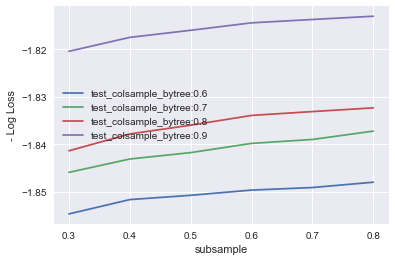

In [11]:
# summarize results
print("Best: %f using %s" % (gsearch3_1.best_score_, gsearch3_1.best_params_))
test_means = gsearch3_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch3_1.cv_results_[ 'std_test_score' ]
train_means = gsearch3_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch3_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch3_1.cv_results_).to_csv('my_preds_subsampleh_colsample_bytree_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(colsample_bytree), len(subsample))
train_scores = np.array(train_means).reshape(len(colsample_bytree), len(subsample))

for i, value in enumerate(colsample_bytree):
    pyplot.plot(subsample, -test_scores[i], label= 'test_colsample_bytree:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'subsample' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'subsample_vs_colsample_bytree1.png' )